# SaVi Chatbot

### Install Library

In [1]:
import random
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
import json
import nltk
import time
import re
import swifter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import transformers
from transformers import BertTokenizer
from transformers import TFBertForSequenceClassification

from nltk.stem import WordNetLemmatizer
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Model

from urllib import request

import warnings
warnings.filterwarnings("ignore")

'''# Package sentence tokenizer
nltk.download('punkt') 
# Package lemmatization
nltk.download('wordnet')
# Package multilingual wordnet data
nltk.download('omw-1.4')'''

"# Package sentence tokenizer\nnltk.download('punkt') \n# Package lemmatization\nnltk.download('wordnet')\n# Package multilingual wordnet data\nnltk.download('omw-1.4')"

### Data Acquisition

In [2]:
url = "https://raw.githubusercontent.com/Handepp/Tugas-Akhir-Chatbot/main/Dataset/Data_Wahana.json"
request.urlretrieve(url, "Data_Wahana.json")

('Data_Wahana.json', <http.client.HTTPMessage at 0x21463012d60>)

In [3]:
# Importing the dataset
with open('Data_Wahana.json') as content:
  data1 = json.load(content)

# Mendapatkan semua data ke dalam list
tags = [] # data tag
inputs = [] # data input atau pattern
responses = {} # data respon
words = [] # Data kata 
classes = [] # Data Kelas atau Tag
documents = [] # Data Kalimat Dokumen
ignore_words = ['?', '!'] # Mengabaikan tanda spesial karakter

for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      # add to our classes list
      if intent['tag'] not in classes:
        classes.append(intent['tag'])

# Konversi data json ke dalam dataframe
data = pd.DataFrame({"patterns":inputs, "tags":tags})

In [4]:
# Cetak data keseluruhan
data

,patterns,tags
0,Siapa kamu?,SaVi.siapa
1,Kamu siapa?,SaVi.siapa
2,Ini apa?,SaVi.siapa
3,Kamu apa?,SaVi.siapa
4,Robot apakah kamu?,SaVi.siapa
...,...,...
278,Belok ke arah kiri,SaVi.kiri
279,kiri kiri kiri,SaVi.kiri
280,Ke kiri,SaVi.kiri
281,Lihat ke kiri,SaVi.kiri


In [5]:
data.tags.value_counts()

SaVi.siapa          15
SaVi.buruk          12
SaVi.sapa           11
SaVi.benar          10
SaVi.kanan          10
SaVi.stop           10
SaVi.usia           10
SaVi.kiri           10
SaVi.hobby          10
SaVi.asal            9
SaVi.ngobrol         9
SaVi.insaf           9
SaVi.mundur          9
SaVi.maju            9
SaVi.suhu            9
SaVi.hump            9
SaVi.siap            8
SaVi.tanggal         7
SaVi.bos             7
SaVi.Baterai         7
SaVi.fast            7
SaVi.medium          7
SaVi.slow            7
SaVi.beban           7
SaVi.lokasi          7
SaVi.hari            7
SaVi.terimakasih     7
SaVi.bantu           7
SaVi.jam             6
SaVi.berpisah        6
SaVi.baik            5
SaVi.malam           5
SaVi.sore            5
SaVi.pagi            5
SaVi.siang           5
Name: tags, dtype: int64

In [6]:
# sort classes
classes = sorted(list(set(classes)))
print (len(classes), "classes", classes)

35 classes ['SaVi.Baterai', 'SaVi.asal', 'SaVi.baik', 'SaVi.bantu', 'SaVi.beban', 'SaVi.benar', 'SaVi.berpisah', 'SaVi.bos', 'SaVi.buruk', 'SaVi.fast', 'SaVi.hari', 'SaVi.hobby', 'SaVi.hump', 'SaVi.insaf', 'SaVi.jam', 'SaVi.kanan', 'SaVi.kiri', 'SaVi.lokasi', 'SaVi.maju', 'SaVi.malam', 'SaVi.medium', 'SaVi.mundur', 'SaVi.ngobrol', 'SaVi.pagi', 'SaVi.sapa', 'SaVi.siang', 'SaVi.siap', 'SaVi.siapa', 'SaVi.slow', 'SaVi.sore', 'SaVi.stop', 'SaVi.suhu', 'SaVi.tanggal', 'SaVi.terimakasih', 'SaVi.usia']


### Preprocessing

In [7]:
def casefolding(text):
  text = text.lower()                               # Mengubah teks menjadi lower case
  text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
  #text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
  text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
  text = text.strip()                               # Menghapus whitespaces
  return text

In [8]:
key= "https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv"
request.urlretrieve(key, "key_norm.csv")
key_norm = pd.read_csv('key_norm.csv')
print(key_norm.head())

   _id      singkat       hasil
0    1         abis       habis
1    2       accent     tekanan
2    3       accept      terima
3    4     accident  kecelakaan
4    5  achievement    prestasi


In [9]:
def text_normalize(text):
  text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()])
  text = str.lower(text)
  return text

In [10]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
  text = stemmer.stem(text)
  return text

In [11]:
def text_preprocessing_process(text):
  text = casefolding(text)
  text = text_normalize(text)
  text = stemming(text)
  return text

In [12]:
%%time
data['patterns'] = data['patterns'].swifter.apply(text_preprocessing_process)

Pandas Apply:   0%|          | 0/283 [00:00<?, ?it/s]

CPU times: total: 13 s
Wall time: 13.1 s


In [13]:
data

,patterns,tags
0,siapa kamu,SaVi.siapa
1,kamu siapa,SaVi.siapa
2,ini apa,SaVi.siapa
3,kamu apa,SaVi.siapa
4,robot apakah kamu,SaVi.siapa
...,...,...
278,belok ke arah kiri,SaVi.kiri
279,kiri kiri kiri,SaVi.kiri
280,ke kiri,SaVi.kiri
281,lihat ke kiri,SaVi.kiri


## BERT

In [14]:
labelencoder = LabelEncoder()
data['tags'] = labelencoder.fit_transform(data['tags'])

In [15]:
df_train, df_test = train_test_split(data, test_size=0.25)
df_val, df_test = train_test_split(df_test, test_size=0.25)

df_train.shape, df_test.shape, df_val.shape

((212, 2), (18, 2), (53, 2))

In [16]:
# Tentukan pre-trained model yang akan digunakan untuk fine-tuning
# Daftar model dapat ditemukan pada https://huggingface.co

PRE_TRAINED_MODEL = 'indobenchmark/indobert-base-p2'  # https://huggingface.co/indobenchmark/indobert-base-p2
bert_tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)  # Load tokenizer dari pre-trained model
vocabulary = bert_tokenizer.get_vocab()

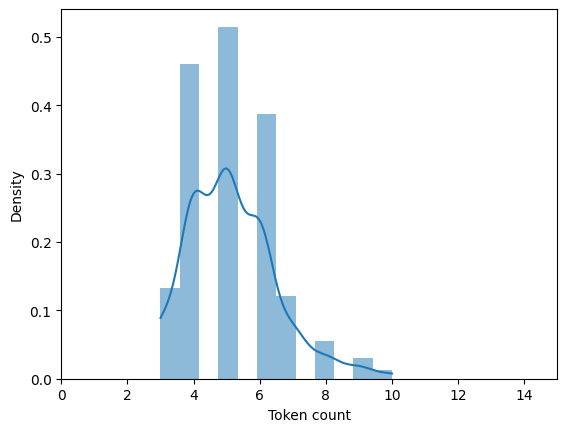

In [17]:
token_lens = []

for txt in data.patterns:
  tokens = bert_tokenizer.encode(txt)
  token_lens.append(len(tokens))

sns.histplot(token_lens, kde=True, stat='density', linewidth=0)
plt.xlim([0, 15]);
plt.xlabel('Token count');

In [18]:
MAX_LEN = 11

In [19]:
def convert_example_to_feature(sentence):  
  return bert_tokenizer.encode_plus(
      sentence, 
      add_special_tokens = True, 
      padding = 'max_length',
      truncation = 'longest_first',
      max_length = MAX_LEN, 
      return_attention_mask = True, 
      return_token_type_ids=True
    )

def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,               # Sebagai token embedding
      "token_type_ids": token_type_ids,     # Sebagai segment embedding
      "attention_mask": attention_masks,    # Sebagai filter informasi mana yang kalkulasi oleh model
  }, label

# Buat fungsi untuk iterasi pada setiap kalimat pada keseluruhan data
def encode(data):
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []
    
  for sentence, label in data.to_numpy():

    bert_input = convert_example_to_feature(sentence)
  
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])

  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [20]:
EPOCHS = 20
BATCH_SIZE = 32
LEARNING_RATE = 5e-5

In [21]:
# Lakukan input formatting menggunakan fungsi sebelumnya pada data keseluruhan data
train_encoded = encode(df_train).batch(BATCH_SIZE)
test_encoded = encode(df_test).batch(BATCH_SIZE)
val_encoded = encode(df_val).batch(BATCH_SIZE)

In [22]:
bert_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=35)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Karena tidak menggunakan one-hot vectors, sehingga loss function dapat menggunakan sparse categorical cross entropy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

# Compile model
bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
%%time
bert_history = bert_model.fit(train_encoded, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_encoded)

Epoch 1/20
7/7 [==============================] - 144s 7s/step - loss: 3.4831 - accuracy: 0.1132 - val_loss: 3.0405 - val_accuracy: 0.3396
Epoch 2/20
7/7 [==============================] - 33s 5s/step - loss: 2.5471 - accuracy: 0.6085 - val_loss: 2.4134 - val_accuracy: 0.4906
Epoch 3/20
7/7 [==============================] - 32s 5s/step - loss: 1.7931 - accuracy: 0.8160 - val_loss: 1.8581 - val_accuracy: 0.6226
Epoch 4/20
7/7 [==============================] - 32s 5s/step - loss: 1.2391 - accuracy: 0.9245 - val_loss: 1.3905 - val_accuracy: 0.8302
Epoch 5/20
7/7 [==============================] - 32s 5s/step - loss: 0.8109 - accuracy: 0.9858 - val_loss: 1.0879 - val_accuracy: 0.8302
Epoch 6/20
7/7 [==============================] - 32s 5s/step - loss: 0.5550 - accuracy: 0.9906 - val_loss: 0.8517 - val_accuracy: 0.8679
Epoch 7/20
7/7 [==============================] - 35s 5s/step - loss: 0.3862 - accuracy: 0.9906 - val_loss: 0.6971 - val_accuracy: 0.8868
Epoch 8/20
7/7 [=================

In [24]:
# Buat fungsi untuk plotting hasil training
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

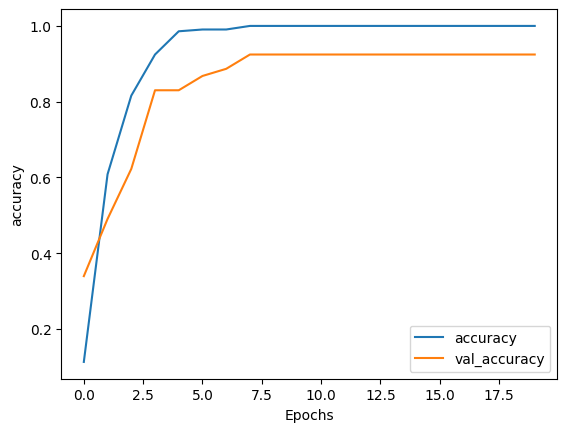

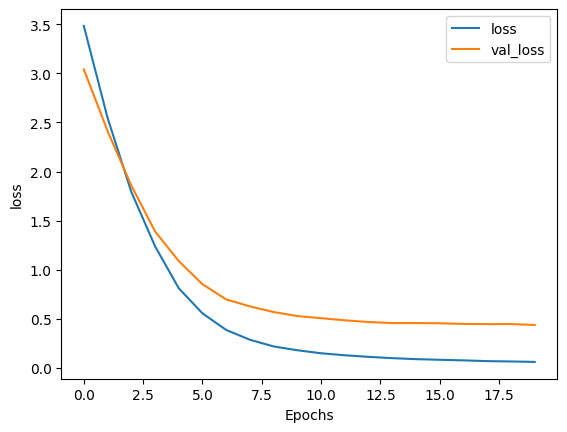

In [25]:
plot_graphs(bert_history, 'accuracy')
plot_graphs(bert_history, 'loss')

In [26]:
bert_model.save_weights('Model/bert-wardas.h5')

In [27]:
score = bert_model.evaluate(test_encoded)

print("Test Accuracy:", score[1])

1/1 [==============================] - 1s 766ms/step - loss: 0.5130 - accuracy: 0.8889
Test Accuracy: 0.8888888955116272
